# Dolphin Data

- Read in and plot dolphin data
- There are 3 dolphins, do we want to create different output data for each dolphin?
- Dolphin IDs are 118181 (female - Lizzy), 118182 (male - Perry ), 118183(male - Bent High Nicks)


In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature

#import configuration location and filepath
from myconfig import *

plt.rcParams['figure.figsize'] = (10,10)

def calculate_direction(lat, lon, center_lat, center_lon):
    dlat = lat - center_lat
    dlon = lon - center_lon
    
    if dlat > 0 and dlon == 0:
        return 'N'
    elif dlat > 0 and dlon > 0:
        return 'NE'
    elif dlat == 0 and dlon > 0:
        return 'E'
    elif dlat < 0 and dlon > 0:
        return 'SE'
    elif dlat < 0 and dlon == 0:
        return 'S'
    elif dlat < 0 and dlon < 0:
        return 'SW'
    elif dlat == 0 and dlon < 0:
        return 'W'
    elif dlat > 0 and dlon < 0:
        return 'NW'
    else:
        return None

# Step 6: Function to calculate Euclidean distance between two lat/lon points
def calculate_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2)


filename = './../Dolphin/DS Sarasota 2012 Combined-Locations.csv'

df = pd.read_csv(filename)
ds = xr.Dataset.from_dataframe(df)

#drop low quality observations
mask = ~ds.Quality.isin(['A', 'B', 'G'])
ds = ds.where(mask,drop=True)
ds

#convert the time to np.datetime64
tem_time = pd.to_datetime(ds['Date'].values, format='%H:%M:%S %d-%b-%Y')
tem_time = tem_time.astype('datetime64[ns]')

ds2 = xr.Dataset(
    {
        'DeployID': ('time', ds.DeployID.data),
        'Latitude': ('time', ds.Latitude.data),
        'Longitude': ('time', ds.Longitude.data)
    },
    coords={'time': tem_time}
)

ds = ds2
ds

<xarray.Dataset> Size: 61kB
Dimensions:    (time: 1904)
Coordinates:
  * time       (time) datetime64[ns] 15kB 2012-05-07T14:09:04 ... 2012-08-15T...
Data variables:
    DeployID   (time) float64 15kB 1.182e+05 1.182e+05 ... 1.182e+05 1.182e+05
    Latitude   (time) float64 15kB 27.48 27.48 27.5 27.47 ... 27.51 27.49 27.51
    Longitude  (time) float64 15kB -82.69 -82.7 -82.65 ... -82.55 -82.67 -82.68

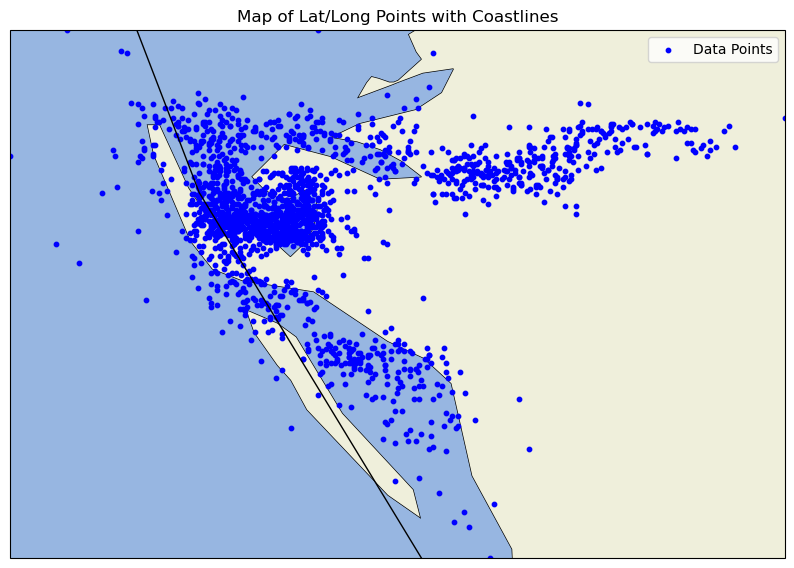

In [2]:
# Step 3: Create a plot with a projection using Cartopy
fig, ax = plt.subplots(figsize=(10, 10),
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Step 4: Plot the data points on the map
ax.scatter(ds['Longitude'], ds['Latitude'], c='blue', s=10, label='Data Points', transform=ccrs.PlateCarree())

# Step 5: Add coastlines to the map
ax.coastlines(resolution='110m')

# Optionally add more map features (borders, land, oceans, etc.)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# Step 6: Resize the map to the region of the points
ax.set_extent([ds['Longitude'].min(), ds['Longitude'].max(),
               ds['Latitude'].min(), ds['Latitude'].max()],
              crs=ccrs.PlateCarree())

# Adding labels and title
plt.title('Map of Lat/Long Points with Coastlines')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.savefig('./figures/dolphin_map.png')

In [3]:
# Calculate the center point (mean latitude and longitude)
center_lat = ds['Latitude'].mean().item()
center_lon = ds['Longitude'].mean().item()
center_point = (center_lat, center_lon)

In [4]:
# Calculate distance of each point from the center point (Euclidean distance)
ds['distance'] = np.sqrt((ds['Latitude'] - center_lat)**2 + (ds['Longitude'] - center_lon)**2)

# Determine direction for each point
directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
farthest_points = {}

# Initialize a dictionary to store farthest points in each direction
for direction in directions:
    farthest_points[direction] = {'lat': None, 'lon': None, 'distance': -1}

# Iterate over the dataset and find the farthest point in each direction
#for lat, lon, distance in zip(ds['Latitude'].values, ds['Longitude'].values, ds['distance'].values):
#    direction = calculate_direction(lat, lon, center_lat, center_lon)
#    if direction and distance > farthest_points[direction]['distance']:
#        farthest_points[direction] = {'lat': lat, 'lon': lon, 'distance': distance}

index = ds['Latitude'].argmax().item()
farthest_points['N'] = {'lat': ds.Latitude[index].item(), 'lon': center_lon, 'distance': ds.distance[index].item()}
index = ds['Latitude'].argmin().item()
farthest_points['S'] = {'lat': ds.Latitude[index].item(), 'lon': center_lon, 'distance': ds.distance[index].item()}
index = ds['Longitude'].argmax().item()
farthest_points['E'] = {'lat': center_lat, 'lon': ds.Longitude[index].item(), 'distance': ds.distance[index].item()}
index = ds['Longitude'].argmin().item()
farthest_points['W'] = {'lat': center_lat, 'lon': ds.Longitude[index].item(), 'distance': ds.distance[index].item()}

#NE
index = ds['Latitude'].argmax().item()
lat2 = center_lat+.5*(ds.Latitude[index].item()-center_lat)
index = ds['Longitude'].argmax().item()
lon2 = center_lon+.5*(ds.Longitude[index].item()-center_lon)
dist2 = np.sqrt((lat2 - center_lat)**2 + (lon2 - center_lon)**2)
farthest_points['NE'] = {'lat': lat2, 'lon': lon2, 'distance': dist2}

#SE
index = ds['Latitude'].argmin().item()
lat2 = center_lat+.5*(ds.Latitude[index].item()-center_lat)
index = ds['Longitude'].argmax().item()
lon2 = center_lon+.5*(ds.Longitude[index].item()-center_lon)
dist2 = np.sqrt((lat2 - center_lat)**2 + (lon2 - center_lon)**2)
farthest_points['SE'] = {'lat': lat2, 'lon': lon2, 'distance': dist2}

#NW
index = ds['Latitude'].argmax().item()
lat2 = center_lat+.5*(ds.Latitude[index].item()-center_lat)
index = ds['Longitude'].argmin().item()
lon2 = center_lon+.5*(ds.Longitude[index].item()-center_lon)
dist2 = np.sqrt((lat2 - center_lat)**2 + (lon2 - center_lon)**2)
farthest_points['NW'] = {'lat': lat2, 'lon': lon2, 'distance': dist2}

#SW
index = ds['Latitude'].argmin().item()
lat2 = center_lat+.5*(ds.Latitude[index].item()-center_lat)
index = ds['Longitude'].argmin().item()
lon2 = center_lon+.5*(ds.Longitude[index].item()-center_lon)
dist2 = np.sqrt((lat2 - center_lat)**2 + (lon2 - center_lon)**2)
farthest_points['SW'] = {'lat': lat2, 'lon': lon2, 'distance': dist2}

# Output the farthest points
for direction, point in farthest_points.items():
    print(f"Farthest point to the {direction}: (Latitude: {point['lat']}, Longitude: {point['lon']}, Distance: {point['distance']:.4f})")

Farthest point to the N: (Latitude: 27.57999992, Longitude: -82.6416578211397, Distance: 0.1639)
Farthest point to the NE: (Latitude: 27.531609209230567, Longitude: -82.52032232056985, Distance: 0.1306)
Farthest point to the E: (Latitude: 27.483218498461138, Longitude: -82.39898682, Distance: 0.2479)
Farthest point to the SE: (Latitude: 27.393609674230568, Longitude: -82.52032232056985, Distance: 0.1508)
Farthest point to the S: (Latitude: 27.30400085, Longitude: -82.6416578211397, Distance: 0.1999)
Farthest point to the SW: (Latitude: 27.393609674230568, Longitude: -82.72282171056986, Distance: 0.1209)
Farthest point to the W: (Latitude: 27.483218498461138, Longitude: -82.8039856, Distance: 0.1652)
Farthest point to the NW: (Latitude: 27.531609209230567, Longitude: -82.72282171056986, Distance: 0.0945)


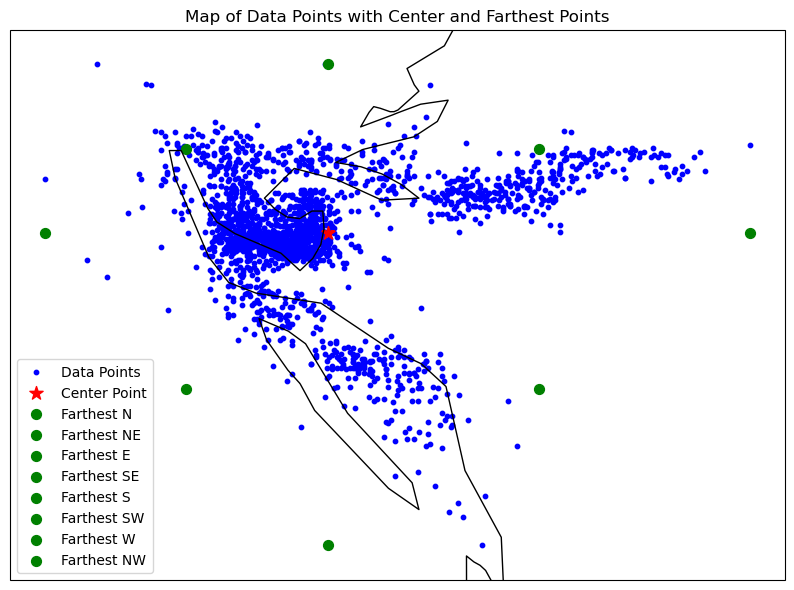

In [5]:
# Create a map using Cartopy
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot coastlines
ax.coastlines()

lons, lats = ds.Longitude,ds.Latitude
# Plot the data points
plt.scatter(lons, lats, color='blue', s=10, label='Data Points')

# Plot the center point
plt.scatter(center_lon, center_lat, color='red', s=100, marker='*', label='Center Point')

# Plot the farthest points in each direction
for direction, point in farthest_points.items():
    plt.scatter(point['lon'], point['lat'], color='green', s=50, label=f'Farthest {direction}')

# Step 5: Set the map extent to the data region
lat_min, lat_max = lats.min(), lats.max()
lon_min, lon_max = lons.min(), lons.max()
ax.set_extent([lon_min - .02, lon_max + .02, lat_min - .02, lat_max + .02], crs=ccrs.PlateCarree())

# Step 6: Add labels and a legend
plt.title('Map of Data Points with Center and Farthest Points')
plt.legend()

# Display the map
plt.savefig('./figures/dolphin_map_with_8_points.png')

In [6]:
# Calculate distance for each point and direction
for lat, lon, distance in zip(ds['Latitude'].values, ds['Longitude'].values, ds['distance'].values):
    direction = calculate_direction(lat, lon, center_lat, center_lon)
    if direction and distance > farthest_points[direction]['distance']:
        farthest_points[direction] = {'lat': lat, 'lon': lon, 'distance': distance}


# For each location, find the closest farthest point
closest_farthest = []

for lat, lon in zip(ds['Latitude'].values, ds['Longitude'].values):
    min_distance = float('inf')
    closest_direction = None
    
    for direction, point in farthest_points.items():
        distance = calculate_distance(lat, lon, point['lat'], point['lon'])
        if distance < min_distance:
            min_distance = distance
            closest_direction = direction
    
    closest_farthest.append(closest_direction)

# Add the closest farthest point to the dataset
ds['closest_farthest_point'] = xr.DataArray(closest_farthest, dims='index')

# Output the dataset with the closest farthest points
print(ds[['Latitude', 'Longitude', 'closest_farthest_point']])

<xarray.Dataset> Size: 61kB
Dimensions:                 (time: 1904, index: 1904)
Coordinates:
  * time                    (time) datetime64[ns] 15kB 2012-05-07T14:09:04 .....
Dimensions without coordinates: index
Data variables:
    Latitude                (time) float64 15kB 27.48 27.48 27.5 ... 27.49 27.51
    Longitude               (time) float64 15kB -82.69 -82.7 ... -82.67 -82.68
    closest_farthest_point  (index) <U2 15kB 'SW' 'SW' 'N' 'N' ... 'N' 'N' 'N'


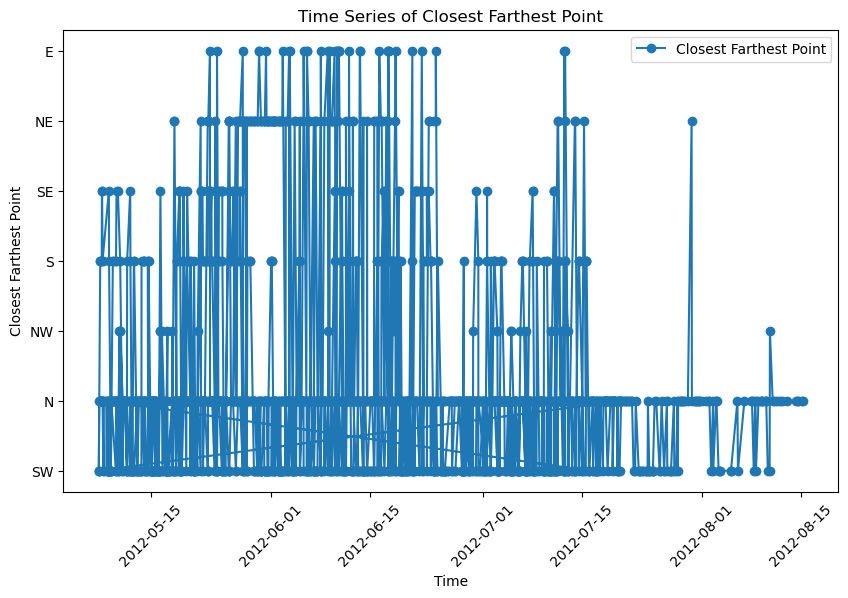

In [7]:
# Plot the closest farthest point as a time series
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(ds['time'], ds['closest_farthest_point'], marker='o', linestyle='-', label='Closest Farthest Point')

# Add labels and a title
plt.title('Time Series of Closest Farthest Point')
plt.xlabel('Time')
plt.ylabel('Closest Farthest Point')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the legend
plt.legend()
plt.savefig('./figures/dolphin_map_timeseries.png')

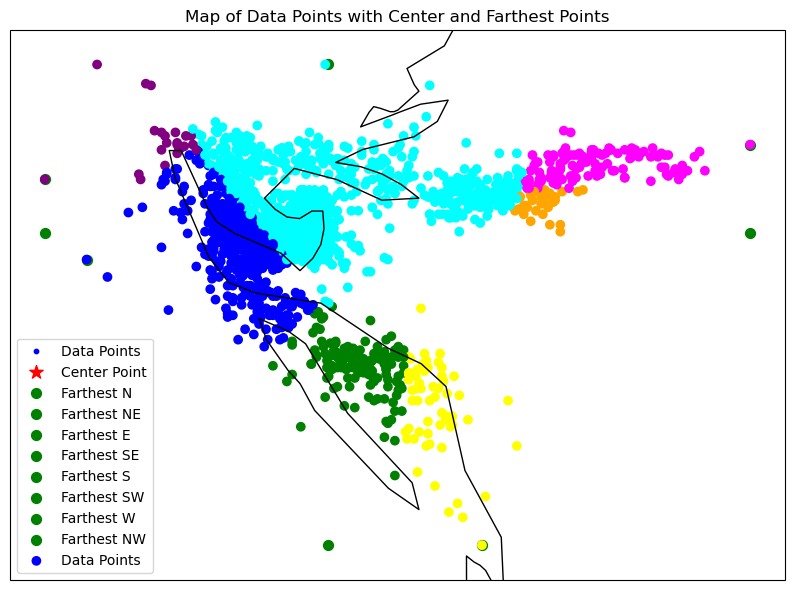

In [8]:
# Color mapping for each farthest point direction
color_map = {
    'N': 'cyan',
    'NE': 'magenta',
    'E': 'orange',
    'SE': 'yellow',
    'S': 'green',
    'SW': 'blue',
    'W': 'red',
    'NW': 'purple'
}
# Step 4: Create a map using Cartopy
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot coastlines
ax.coastlines()

lons, lats = ds.Longitude,ds.Latitude
# Plot the data points
plt.scatter(lons, lats, color='blue', s=10, label='Data Points')

# Plot the center point
plt.scatter(center_lon, center_lat, color='red', s=100, marker='*', label='Center Point')

# Plot the farthest points in each direction
for direction, point in farthest_points.items():
    plt.scatter(point['lon'], point['lat'], color='green', s=50, label=f'Farthest {direction}')

closest_farthest_points = ds['closest_farthest_point'].values  # Assuming this is available
colors = [color_map[direction] for direction in closest_farthest_points]

ax.scatter(ds['Longitude'], ds['Latitude'], color=colors, marker='o', label='Data Points', transform=ccrs.PlateCarree())

# Set the map extent to the data region
lat_min, lat_max = lats.min(), lats.max()
lon_min, lon_max = lons.min(), lons.max()
ax.set_extent([lon_min - .02, lon_max + .02, lat_min - .02, lat_max + .02], crs=ccrs.PlateCarree())

# Add labels and a legend
plt.title('Map of Data Points with Center and Farthest Points')
plt.legend()

# Display the map
plt.savefig('./figures/dolphin_map_mapped_to_point.png')


In [9]:
#mask
mask = ds.DeployID==118181
ds2 = ds.where(mask,drop=True)
nc_fname = output_path2+'dolphin_Lizzy.nc'
csv_fname = output_path2+'dolphin_Lizzy.csv'
ds2.to_netcdf(nc_fname) 
df = ds2.to_dataframe()
df.to_csv(csv_fname)

mask = ds.DeployID==118182
ds2 = ds.where(mask,drop=True)
nc_fname = output_path2+'dolphin_Perry.nc'
csv_fname = output_path2+'dolphin_Perry.csv'
ds2.to_netcdf(nc_fname) 
df = ds2.to_dataframe()
df.to_csv(csv_fname)

mask = ds.DeployID==118183
ds2 = ds.where(mask,drop=True)
nc_fname = output_path2+'dolphin_BentHighNick.nc'
csv_fname = output_path2+'dolphin_BentHighNick.csv'
ds2.to_netcdf(nc_fname) 
df = ds2.to_dataframe()
df.to_csv(csv_fname)